<center><font size = "10"> Week 8 - Synapses<center>
<center><font size = "8">Tutorial 01: NMDA and AMPA model<center>

<font size='3'><font color='white'> In this tutorial you will see how to:
    
<font size='3'><font color='white'> - create a synapse model of AMPA and NMDA glutamate receptors described in a MOD file.
    
<font size='3'><font color='white'> - integrate the synaptic models into a simple neuron.
    
<font size='3'><font color='white'> - make simulations to understand NMDA and AMPA receptors mechanisms
    
AMPA receptors are ion channels activated by glutamate, they hyperpolarize the cell and open and close quickly (low time constant).
NMDA receptors are likewise hyperpolarizing and activated by glutamate, but their dynamics are slower and their opening/closing is affected by membrane potential as well as the presence of glutamate.

Glutamate is the neurotransmitter produced by many of the cells in the brain, and as the ion channels that react to it are hyperpolarizing, these cells are called excitatory.
It also is the flavor molecule responsible for the 'meaty' or 'umami' flavor of meats, mushrooms, seaweeds, etc. It isn't relevant to anything in the course but just know that your excitatory synapses are delicious.
    
Through the release of glutamate in a presynaptic cell (when that cell fires an action potential) onto the AMPA and NMDA receptors in a post-synaptic cell increases that cell's membrane potential and makes it more likely to fire an action potential itself.
    
<img src="images/NMDA_AMPA_pic.png" width="920"> 
    
*Slides: 20, 21 and 22 from lecture.

### Compile the MOD files

In [1]:
!nrnivmodl

/Users/wesleymonteith/miniconda3/envs/biophysics/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Tutorial_8-20241116
Mod files: "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod" "./SimpleAMPA_NMDA.mod" "./TsodyksMarkram_AMPA_NMDA.mod" "./vecevent.mod"

Creating 'x86_64' directory for .o files.

 -> NMODL ../SK_E2.mod
 -> NMODL ../SKv3_1.mod
 -> NMODL ../NaTs2_t.mod
 -> Compiling mod_func.cpp
Translating SKv3_1.mod into /Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Tutorial_8-20241116/x86_64/SKv3_1.c
Translating NaTs2_t.mod into /Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Tutorial_8-20241116/x86_64/NaTs2_t.c
Translating SK_E2.mod into /Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Tutorial_8-20241116/x

### Load the modules and hoc files that will be used

In [2]:
import neuron
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load external files & initialize
h.load_file("stdrun.hoc")
h.stdinit()

--No graphics will be displayed.


0.0

### A neuron to host your synapse

<font size='3'>As the point of the tutorial is understand AMPA and NMDA receptors mechanism, we will create a single compartment soma neuron to host the synapse.

In [3]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert("pas")

__nrnsec_0x7f7b8a197000

In [4]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

## the synapse model

The SimpleAmpa_NMDA object is defined in SimpleAMPA_NMDA.mod.
`POINT_PROCESS SimpleAMPA_NMDA` states that it is a subclass of h.PointProcess, which is the norm for synapse models.
The parameters of the model and what they mean are written in the PARAMETERS block.
It implements a double exponential function for each receptor type (see below).

You can find more documentation on  modfiles here https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#model-description-language


Create the synapse at the center of the soma compartment

In [5]:
synapse = h.SimpleAMPA_NMDA(soma(0.5))

### Define the stimulus:

<font size='3'> 8 spikes at 20Hz + 1 spike 500 ms later

In [6]:
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0  # In units of [nS] due to the gmax scaling factor in our .mod file

### Create a recorder for the synaptic conductance, current, the soma voltage, and the time intervals

In [7]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

Vector[4]

### AMPA conductance

To look at only the AMPA conductance, let's set NMDA conductance to 0.



In [8]:
DURATION = 1100
synapse.gmax_NMDA = 0.0
synapse.gmax_AMPA = 0.001  # uS
h.finitialize(-70)
h.continuerun(DURATION)
# note we use an alternative way to run to the h.continuerun we have so far.

0.0

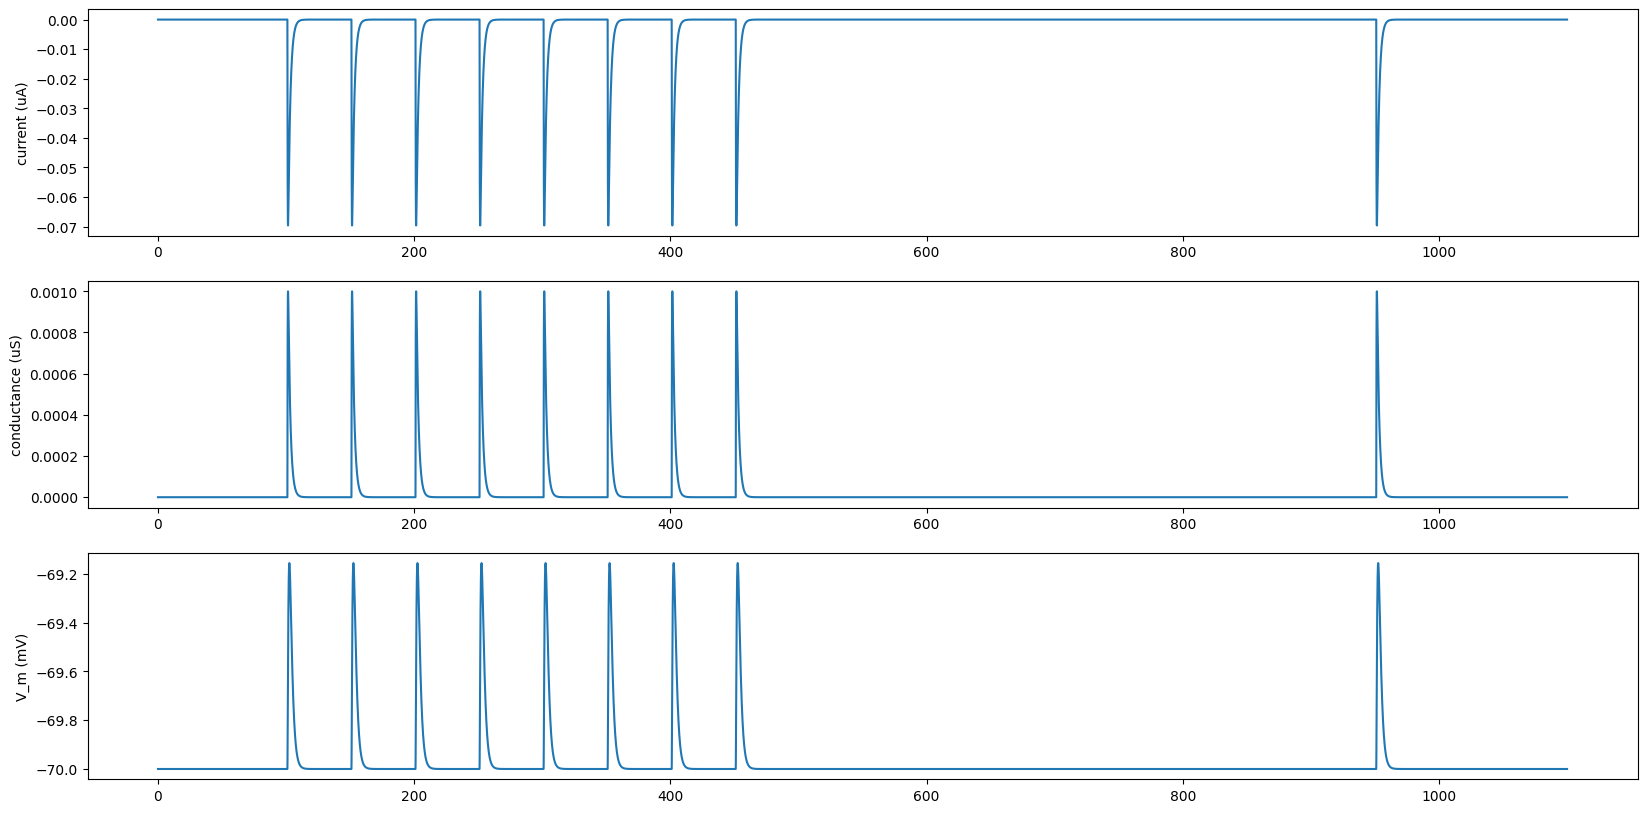

In [9]:
values = i_syn, g_syn, v_soma
labels = 'current (uA)', 'conductance (uS)', 'V_m (mV)'
f, axs = plt.subplots(3, 1, figsize=(20, 10))
for ax, label, value in zip(axs, labels, values):
    ax.plot(time, value)
    ax.set_ylabel(label)


#### Conductance

<font size='3'>The dual exponential model (exponential activation, exponential deactivation) for the conductance time course has a closed form for the response due to a single pulse.
Below we verify the model in the .mod file implementation running in NEURON against this closed form solution. 

<center><img src="images/DualExpConductance.png" width="600"><center>
    
*Slide 34 of lecture


In [10]:
def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = np.array(t)
    time_to_peak = (tau_r * tau_d) / (tau_d - tau_r) * np.log(tau_d / tau_r)
    factor = -np.exp(-time_to_peak / tau_r) + np.exp(-time_to_peak / tau_d)
    f_dual_exp = lambda t: (np.exp(-t / tau_d) - np.exp(-t / tau_r)) / factor
    
    dual_exp = np.zeros_like(t)
    dual_exp[t >= t_start] = f_dual_exp(t[t >= t_start] - t_start)
    
    return dual_exp

In [11]:
def compare_exp(t, g, tau_r, tau_d, t_start, t_end):
    time = np.array(t)
    g_syn = np.array(g)

    firstspike = np.logical_and(time > t_start, time < t_end)
    plt.figure(figsize=(20, 10))
    plt.plot(time[firstspike], g_syn[firstspike], label="conductance")
    plt.plot(
        time[firstspike],
        0.001 * connection.weight[0] * dual_exp(
            time[firstspike], tau_r, tau_d, t_start=100.0 + connection.delay
        ),
        "r--",
        lw=2,
        label="math. expr.",
    )
    plt.legend();



### NMDA conductance

Now let's take a look at the NMDA receptor alone.
    channels
At resting membrane potentials, magnesium ions block the NMDA channels.
Without any AMPA conductance to depolarize the membrane, this means we won't see much of a current.
So, to see the dynamics of NMDA receptors we will set the magnesium concentration to zero.

In [12]:
synapse.gmax_NMDA = 0.001  # uS
synapse.mg = 0.0  # mM
synapse.gmax_AMPA = 0  # uS
h.finitialize(-70)
h.continuerun(DURATION)

0.0

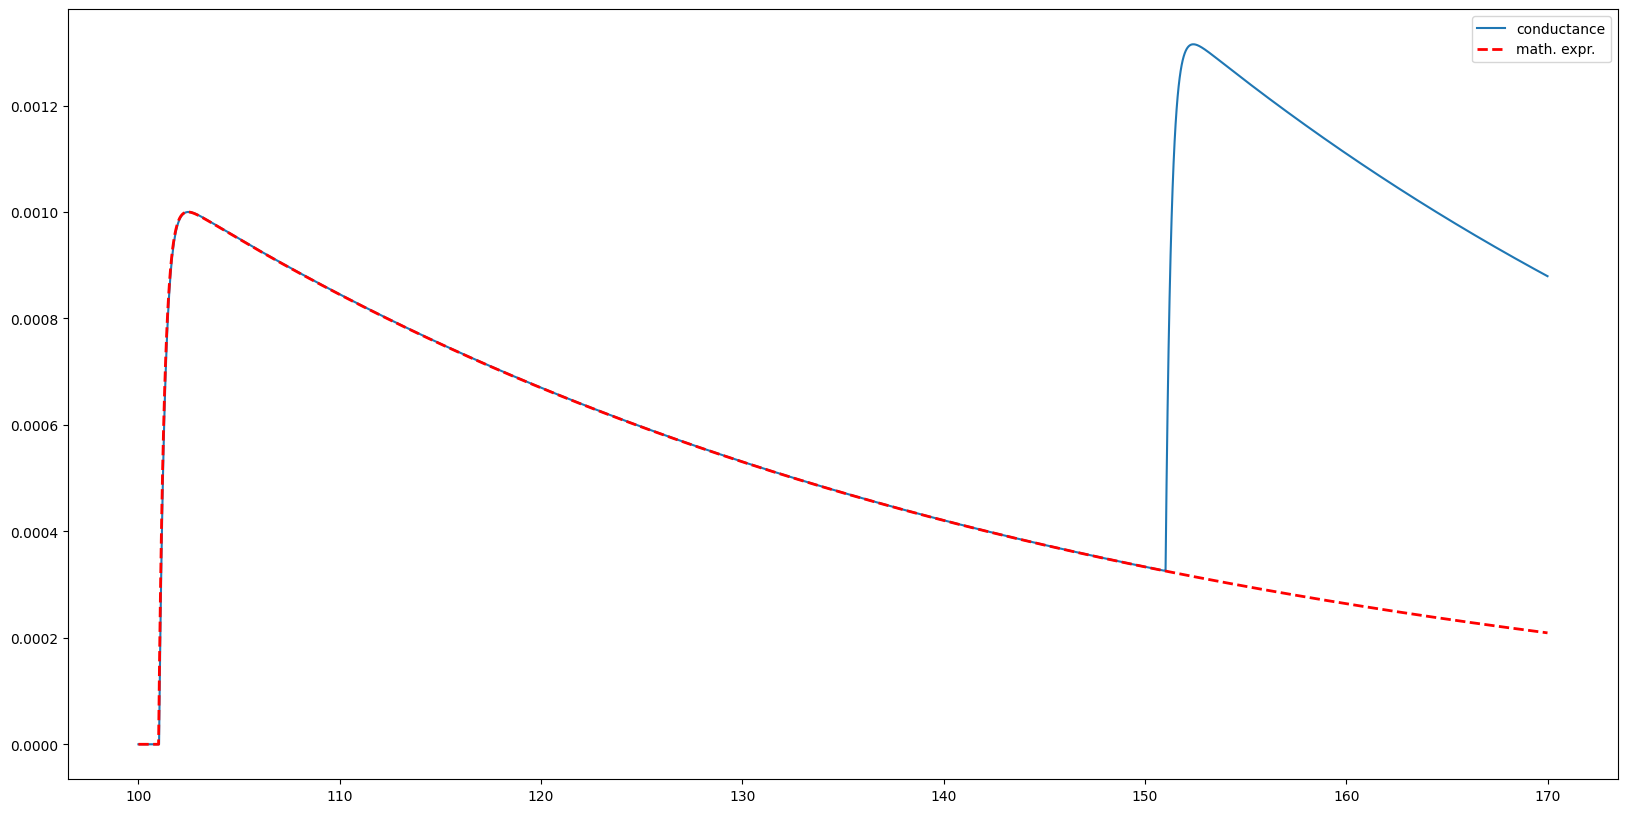

In [13]:
# This could take a while
compare_exp(time, g_syn, synapse.tau_r_NMDA, synapse.tau_d_NMDA, 100, 170)

### AMPA and NMDA conductance

<font size='3'>Finally, let's configure the synapse to realistic biological ranges for the AMPA and NMDA conductances, and the Mg2+ concentration. Then, let's see the dynamics.

In [14]:
synapse.gmax_AMPA = 0.001  # uS
synapse.gmax_NMDA = (
    0.7 * 0.001
)  # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0  # mM
g_NMDA = h.Vector()
g_NMDA.record(synapse._ref_g_NMDA)
g_AMPA = h.Vector()
g_AMPA.record(synapse._ref_g_AMPA)
h.finitialize(-70)
h.continuerun(DURATION)

0.0

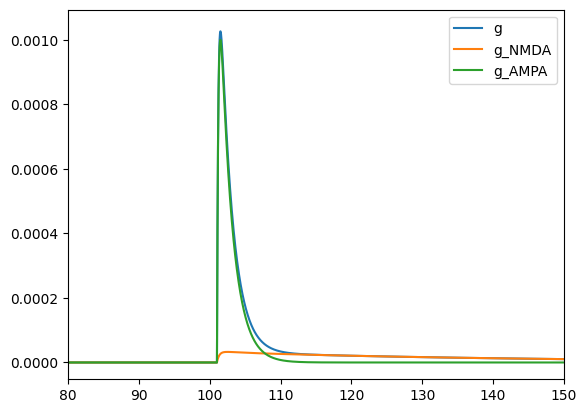

In [15]:
# This could take a while
plt.figure()
plt.plot(time, g_syn, label="g")
plt.plot(time, g_NMDA, label="g_NMDA")
plt.plot(time, g_AMPA, label="g_AMPA")
plt.xlim(80, 150)
#plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()